In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib.ticker import FuncFormatter
import scipy.optimize as op
from preprocessing import *
plt.style.use("dark_background") # Config plots for dark mode, delete if on light mode
plt.rcParams['figure.dpi'] = 150 # Hi-res plots

In [3]:
def N(t_scalar, t):
    """
    Returns the number of times in t less than or equal to t_scalar.
    Is used to compute N(t_{i,k}) and N'(t_{i,k}) depending on whether t above is t or t_prime
    """
    return np.searchsorted(t, t_scalar, side="right")

def get_time_differences(t, t_prime):
    """
    Input: (sorted) times for a particular station i
    Output: List of differences indexed by [h][k] for this station i
    """

    # h goes until N(t[-1], t)
    T = end_T
    differences = []
    for h in range(N(T, t)):
        differences_list = []
        # Construct list of t_ih - t'_ik for k = 1 to N'(T)
        differences_list.append(t[h] - t_prime[N(t[h-1], t_prime):N(t[h], t_prime)])

        differences.append(np.asarray(differences_list))

    return differences

def m4_compensator_helper(t_scalar, t, t_prime):
    """
    Computes the lists that are required for the compensator function outside of it (without the parameters)
    """
    t_difference = t_scalar - t[:N(t_scalar, t)]
    t_prime_difference = t_scalar - t_prime[:N(t_scalar, t_prime)]
    return t_difference, t_prime_difference

In [4]:
# def get_time_differences_2(t, t_prime):
#     """
#     Input: (sorted) times for a particular station i
#     Output: List of differences indexed by [h][k] for this station i
#     """

#     # h goes until N(t[-1], t)
#     T = end_T
#     differences = np.array([])
#     for h in range(N(T, t)):
#         differences_list = []
#         # Construct list of t_ih - t'_ik for k = 1 to N'(T)
#         differences_list.append(t[h] - t_prime[N(t[h-1], t_prime):N(t[h], t_prime)])

#         differences = np.append(differences, np.asarray(differences_list))

#     return differences

In [5]:
# def compensator_m4(t_scalar, t, t_prime, alpha_i, beta_i, alpha_i_prime, beta_i_prime,lambda_i):
#     """
#     t_scalar: scalar value where Lambda_i(t) is to be evaluated
#     t_prime: list of arrival times at station i

#     NOTE: t_prime NEEDS TO BE SORTED HERE.
#     """

#     term1 = lambda_i * t_scalar
#     term2 = -(alpha_i_prime / beta_i_prime) * np.sum(np.exp(-beta_i_prime * (t_scalar - t_prime[:N(t_scalar, t_prime)]))-1)
#     term3 = -(alpha_i / beta_i) * np.sum(np.exp(-beta_i * (t_scalar - t[:N(t_scalar, t)]))-1)
#     return term1 + term2 + term3


In [12]:
def B_m4(h, t, t_prime, beta, time_differences):

    """
    Returns a list of [B_i(1), ..., B_i(h)]

    NOTE: t_prime NEEDS to be sorted here

    time_differences: time differences double list for station i

    Note all index variables such as h, k, etc start at 1, like the mathematical notation.
    """
    B = [np.sum(np.exp(-beta*(t[0] - t_prime[:N(t[0], t_prime)])))]

    # Append the rest
    for l in range(1, h):
        # First term in recursive formula for B_i(h)
        term1 = np.exp(-beta*(t[l] - t[l-1])) * B[l-1]
        term2 = np.sum(np.exp(-beta*(time_differences[l])))
        B.append(term1 + term2)
    return np.array(B)


def A_m4(h, t, beta):
    A = [0]
    for j in range(1, h):
            A.append(np.exp(-beta*(t[j] - t[j-1]))*(1+A[j-1]))
    return np.asarray(A)
import numpy as np


# def m4_log_likelihood(t, t_prime, time_differences, alpha_i, beta_i, alpha_i_prime, beta_i_prime, lambda_i):
#     """
#     Gives log likelihood of our five parameters. 
#     t: start times from station i
#     t_prime: end times at station i

#     NOTE: t_prime NEEDS TO BE SORTED HERE
#     """
    
#     T = end_T # TODO: Is this how we get big T?

#     # Get A list
#     A_ = new_A(len(t), t, beta_i)

#     # Get B list 
#     B_ = new_B(len(t), t, t_prime, beta_i_prime, time_differences)

#     term1 = np.sum(np.log(lambda_i + alpha_i_prime*B_[:len(t)+1] + alpha_i*A_[:len(t)+1]))

#     term2 = -compensator_m4(T, t, t_prime, alpha_i, beta_i, alpha_i_prime, beta_i_prime, lambda_i)

#     return term1 + term2


In [13]:
def compensator_m4(t_scalar, t_precomputed, t_prime_precomputed, lambda_i, alpha_i, alpha_i_prime, beta_i, beta_i_prime):
    """
    Evaluates compensator using already pre-computed list terms so we don't compute it every time.
    """
    term1 = lambda_i * t_scalar
    term2 = -(alpha_i_prime / beta_i_prime) * np.sum(np.exp(-beta_i_prime * (t_prime_precomputed))-1)
    term3 = -(alpha_i / beta_i) * np.sum(np.exp(-beta_i * (t_precomputed))-1)
    return term1 + term2 + term3

def m4_log_likelihood(t_params,
 lambda_i, alpha_i, alpha_i_prime, beta_i, beta_i_prime):
    """
    Gives log likelihood of our five parameters. 
    t: start times from station i
    t_prime: end times at station i

    NOTE: t_prime NEEDS TO BE SORTED HERE
    """
    # t_params: t, trunc_t, tprime, trunc_tprime, time_diffs
    t, t_precomputed, t_prime, t_prime_precomputed, time_differences = t_params
    length_t = N(end_T, t)
    T = end_T
    A_ = A_m4(length_t, t, beta_i)
    B_ = B_m4(length_t, t, t_prime, beta_i_prime, time_differences)
    term1 = np.sum(np.log(lambda_i + alpha_i*A_ + alpha_i_prime*B_))
    term2 = -compensator_m4(T, t_precomputed, t_prime_precomputed, lambda_i, alpha_i, alpha_i_prime,beta_i, beta_i_prime)

    return term1 + term2

In [14]:
time_diffs = {}
for st_id in tqdm(train_sorted_start_ids):
    time_diffs[st_id] = get_time_differences(t_per_station[st_id], t_prime_per_station[st_id])

100%|██████████| 789/789 [00:13<00:00, 58.67it/s]


In [15]:
trunc_t_per_station = {}
for st_id in tqdm(train_sorted_start_ids):
    t = t_per_station[st_id]
    t_prime = t_prime_per_station[st_id]
    trunc_t_per_station[st_id] = m4_compensator_helper(end_T, t, t_prime)[0]
trunc_t_prime_per_station = {}
for st_id in tqdm(train_sorted_start_ids):
    t = t_per_station[st_id]
    t_prime = t_prime_per_station[st_id]
    trunc_t_prime_per_station[st_id] = m4_compensator_helper(end_T, t, t_prime)[1]

100%|██████████| 789/789 [00:00<00:00, 45644.34it/s]


In [16]:
# combine to new dict called station parameters: ordered as t, trunc_t, tprime, trunc_tprime, time_diffs
station_time_parameters = {}
for st_id in tqdm(train_sorted_start_ids):
    station_time_parameters[st_id] = [t_per_station[st_id], trunc_t_per_station[st_id], t_prime_per_station[st_id], trunc_t_prime_per_station[st_id], time_diffs[st_id]]

100%|██████████| 789/789 [00:00<00:00, 131300.82it/s]


## Finding the parameters using likelihood optimisation

In [17]:
model_2_params = pd.read_csv("../data/N_M_params.csv", index_col=0)
model_3_params = pd.read_csv("../data/M3_train_params.csv", index_col=0)
model_3_params

,alpha,beta,lambda
1,0.020179,0.035553,7.705058e-03
2,0.015271,0.016036,1.213006e-03
3,0.004644,0.004644,3.779973e-17
4,0.009820,0.023543,9.676464e-03
5,0.011876,0.012869,1.258996e-03
...,...,...,...
836,0.014502,0.039605,1.707352e-02
838,0.006228,0.006470,4.663218e-04
839,0.023140,0.028994,8.233945e-03
840,0.018468,0.019006,2.030979e-04


In [18]:
unconverged_it1 = []
N_stat = len(train_sorted_start_ids)+1
optimal_parameters_it1 = {}
for st_id in tqdm(train_sorted_start_ids[:N_stat]):
    # m2_station_params = model_2_params.loc[st_id].to_numpy()
    # m3_station_params = model_3_params.loc[st_id].to_numpy()
    #x0 = [np.log(m2_station_params[0]), np.log(m2_station_params[1] -m2_station_params[0] ), np.log(m3_station_params[0]), np.log(m3_station_params[1] - m3_station_params[0]), np.log(m3_station_params[-1])] # np.log(rates_dict[station.start_id.unique()[0]])]
    x0 = -np.ones(5) * 3
    op_m4_log_likelihood = lambda x: -m4_log_likelihood(station_time_parameters[st_id], np.exp(x[0]), np.exp(x[1]), np.exp(x[2]), np.exp(x[1]) + np.exp(x[3]), np.exp(x[2]) + np.exp(x[4]))
    sol = op.minimize(op_m4_log_likelihood, x0, method="Nelder-Mead")
    if sol.success:
        transformed_lambda = np.exp(sol.x[0])
        transformed_alpha = np.exp(sol.x[1])
        transformed_alpha_prime = np.exp(sol.x[2])
        transformed_beta = np.exp(sol.x[1]) + np.exp(sol.x[3])
        transformed_beta_prime = np.exp(sol.x[2]) + np.exp(sol.x[4])
        max_params = [transformed_lambda, transformed_alpha, transformed_alpha_prime, transformed_beta, transformed_beta_prime]
        optimal_parameters_it1[st_id] = max_params

    else:
        unconverged_it1.append(st_id)
        print(f"{st_id} failed to converge.")

  6%|▋         | 51/789 [06:07<1:25:13,  6.93s/it]

53 failed to converge.


 32%|███▏      | 253/789 [37:10<1:15:55,  8.50s/it]

263 failed to converge.


 40%|████      | 319/789 [1:59:13<1:58:58, 15.19s/it]   

332 failed to converge.


 42%|████▏     | 333/789 [2:01:33<1:44:52, 13.80s/it]

348 failed to converge.


 46%|████▋     | 365/789 [2:05:39<50:05,  7.09s/it]  

382 failed to converge.


 47%|████▋     | 373/789 [2:06:57<54:49,  7.91s/it]  

391 failed to converge.


 63%|██████▎   | 494/789 [2:21:01<31:49,  6.47s/it]  

528 failed to converge.


 70%|███████   | 554/789 [2:28:28<21:47,  5.56s/it]

594 failed to converge.


100%|██████████| 789/789 [2:57:59<00:00, 13.54s/it]


In [20]:
unconverged_it2 = []
optimal_parameters_it2 = {}
for st_id in tqdm(unconverged_it1):
    # m2_station_params = model_2_params.loc[st_id].to_numpy()
    # m3_station_params = model_3_params.loc[st_id].to_numpy()
    #x0 = [np.log(m2_station_params[0]), np.log(m2_station_params[1] -m2_station_params[0] ), np.log(m3_station_params[0]), np.log(m3_station_params[1] - m3_station_params[0]), np.log(m3_station_params[-1])] # np.log(rates_dict[station.start_id.unique()[0]])]
    x0 = -np.ones(5) * 5
    op_m4_log_likelihood = lambda x: -m4_log_likelihood(station_time_parameters[st_id], np.exp(x[0]), np.exp(x[1]), np.exp(x[2]), np.exp(x[1]) + np.exp(x[3]), np.exp(x[2]) + np.exp(x[4]))
    sol = op.minimize(op_m4_log_likelihood, x0, method="Nelder-Mead")
    if sol.success:
        transformed_lambda = np.exp(sol.x[0])
        transformed_alpha = np.exp(sol.x[1])
        transformed_alpha_prime = np.exp(sol.x[2])
        transformed_beta = np.exp(sol.x[1]) + np.exp(sol.x[3])
        transformed_beta_prime = np.exp(sol.x[2]) + np.exp(sol.x[4])
        max_params = [transformed_lambda, transformed_alpha, transformed_alpha_prime, transformed_beta, transformed_beta_prime]
        optimal_parameters_it1[st_id] = max_params

    else:
        unconverged_it2.append(st_id)
        print(f"{st_id} failed to converge.")

100%|██████████| 8/8 [01:11<00:00,  8.97s/it]


789

In [26]:
m4_param_df = pd.DataFrame(optimal_parameters_it1.values(), index=optimal_parameters_it1.keys(), columns = ["lambda", "alpha", "alpha_prime", "beta", "beta_prime"])
m4_param_df.to_csv("../data/M4_train_params.csv")
m4_param_df.head()

,lambda,alpha,alpha_prime,beta,beta_prime
1,0.004289,0.013056,0.017923,0.031378,0.051294
2,0.000957,0.185765,0.012679,1.004565,0.016323
3,0.000042,0.039154,0.003156,0.099732,0.005210
4,0.007390,0.229210,0.007624,1.002632,0.023494
5,0.001123,0.135349,0.009782,0.695608,0.013202


## Assessing fit for model 4

In [58]:
# m4_param_df = pd.DataFrame(optimal_parameters.values(), index=optimal_parameters.keys(), columns = ["alpha", "beta", "alpha_prime", "beta_prime", "lambda"])
# m4_param_df.head() 
# m4_param_df.to_csv("../data/M4_train_params.csv")

,alpha,beta,alpha_prime,beta_prime,lambda
1,0.013184,0.032049,0.017776,2.840562,0.004302
2,0.184808,1.001373,0.012741,1.299733,0.000964
3,0.039253,0.099960,0.003160,1.654810,0.000045
4,0.222189,0.965928,0.007489,3.104779,0.007395


In [98]:
test_precomputed_t_dict = {}
test_precomputed_t_prime_dict = {}
for st_id in tqdm(train_sorted_start_ids[:N_stat]):
    tprime = test_t_prime_per_station[st_id]
    time = test_t_per_station[st_id]
    precomputed_t_lambda = lambda x: m4_compensator_helper(x, time, tprime)[0]
    precomputed_t_prime_lambda = lambda x: m4_compensator_helper(x, time, tprime)[1]
    test_precomputed_t_dict[st_id] = np.asarray([precomputed_t_lambda(t) for t in time], dtype=object)
    test_precomputed_t_prime_dict[st_id] = np.asarray([precomputed_t_prime_lambda(t) for t in time], dtype=object)



100%|██████████| 50/50 [00:00<00:00, 81.41it/s]


In [99]:
compensated_times_dict = {}
for st_id in tqdm(train_sorted_start_ids[:N_stat]):
    params = m4_param_df.loc[st_id].to_numpy()
    tprime = test_t_prime_per_station[st_id]
    time = test_t_per_station[st_id]
    comp_st = lambda x: compensator_m4(x, m4_compensator_helper(x, time, tprime)[0],m4_compensator_helper(x, time, tprime)[1] , params[0], params[1], params[2], params[3], params[4])
    compensated_times_dict[st_id] = [comp_st(t) for t in time]

100%|██████████| 50/50 [00:01<00:00, 41.05it/s]


In [100]:
m4_p_values = {}

for st_id in tqdm(test_sorted_start_ids[:N_stat]):
    inter_arrival_times = np.diff(compensated_times_dict[st_id])
    inter_arrival_times = np.insert(inter_arrival_times,0,compensated_times_dict[st_id][0])
    station_p_values = np.exp(-inter_arrival_times)
    m4_p_values[st_id] = station_p_values

100%|██████████| 50/50 [00:00<00:00, 13543.99it/s]


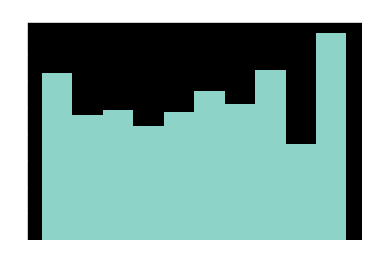

In [101]:
plt.title("Histogram of p-values for station 1 using Model 4")
plt.hist(m4_p_values[1])
plt.show()

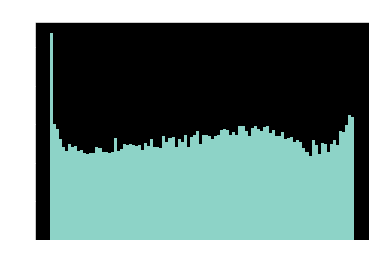

In [103]:
joined_p_values = np.concatenate(np.asarray(list(m4_p_values.values()), dtype=object))
n, bins, patches = plt.hist(joined_p_values, bins=100)
ax = plt.gca()
def lblFormat(n, pos):
    return str(int(n / 1e3))
lblFormatter = FuncFormatter(lblFormat)
ax.yaxis.set_major_formatter(lblFormatter)
plt.title("Histogram of p-values for all stations for Model 4")
plt.xlabel("P-value")
plt.ylabel("Counts (Thousands)")
plt.savefig("../figures/p-values_m3.png")
plt.show()